# Assignment 7
## Group Members:
* ### Nils Dunlop, e-mail: gusdunlni@student.gu.se
* ### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se

## Task 1

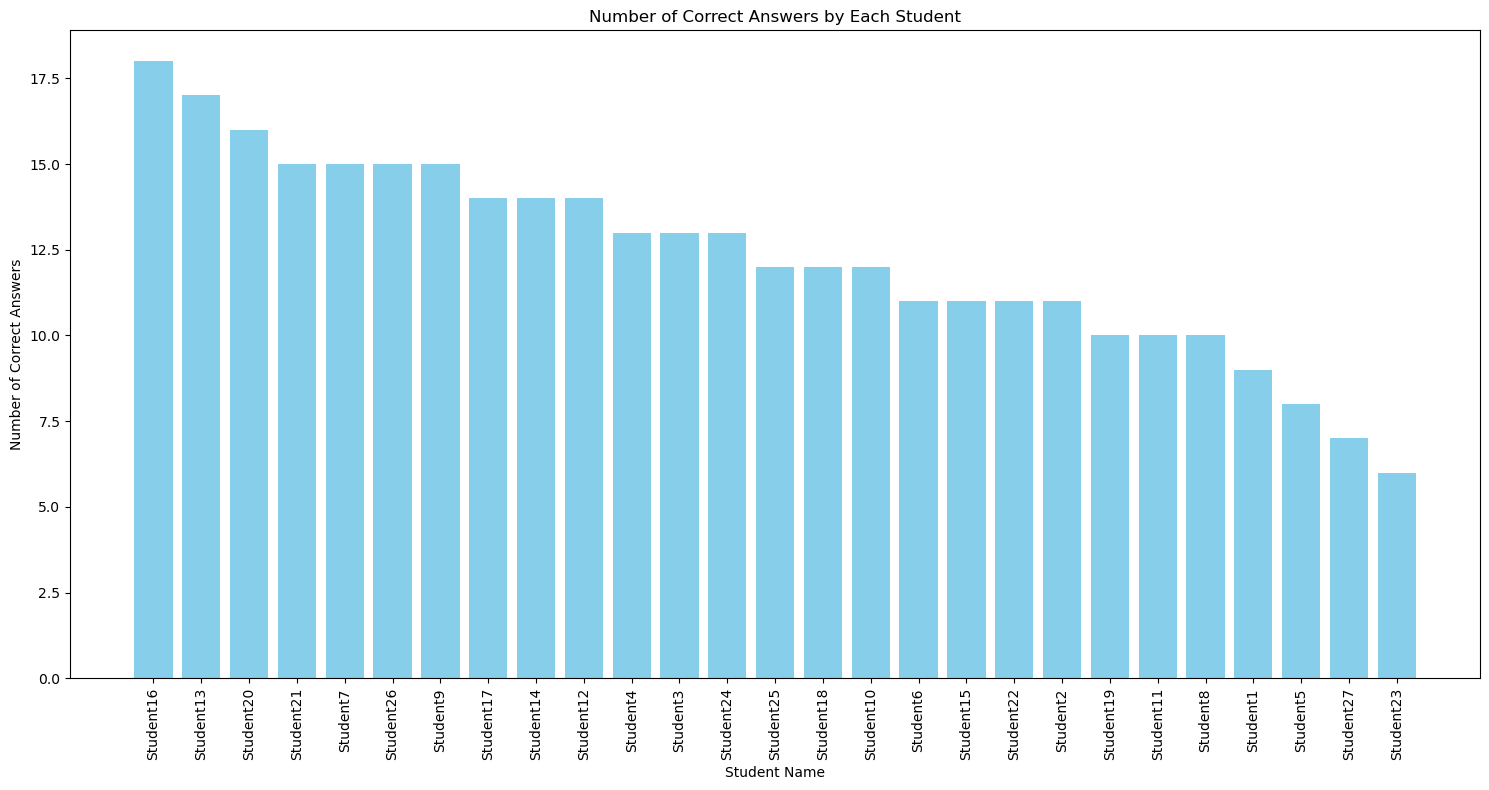

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)

poll_info = pd.read_csv('poll_info.csv', delimiter='\t')
poll_report = pd.read_csv('poll_report.csv', delimiter=';')

merged_df = poll_report.merge(poll_info, left_on='Question ID', right_on='Question')

merged_df['is_correct'] = merged_df['Correct Answer'] == merged_df['Student Answer']

student_scores = merged_df.groupby('User Name')['is_correct'].sum().reset_index()

student_scores = student_scores.sort_values(by='is_correct', ascending=False)

# Plotting
plt.figure(figsize=(15,8))
plt.bar(student_scores['User Name'], student_scores['is_correct'], color='skyblue')
plt.ylabel('Number of Correct Answers')
plt.xlabel('Student Name')
plt.xticks(rotation=90)
plt.title('Number of Correct Answers by Each Student')
plt.tight_layout()
plt.show()

## Task 2

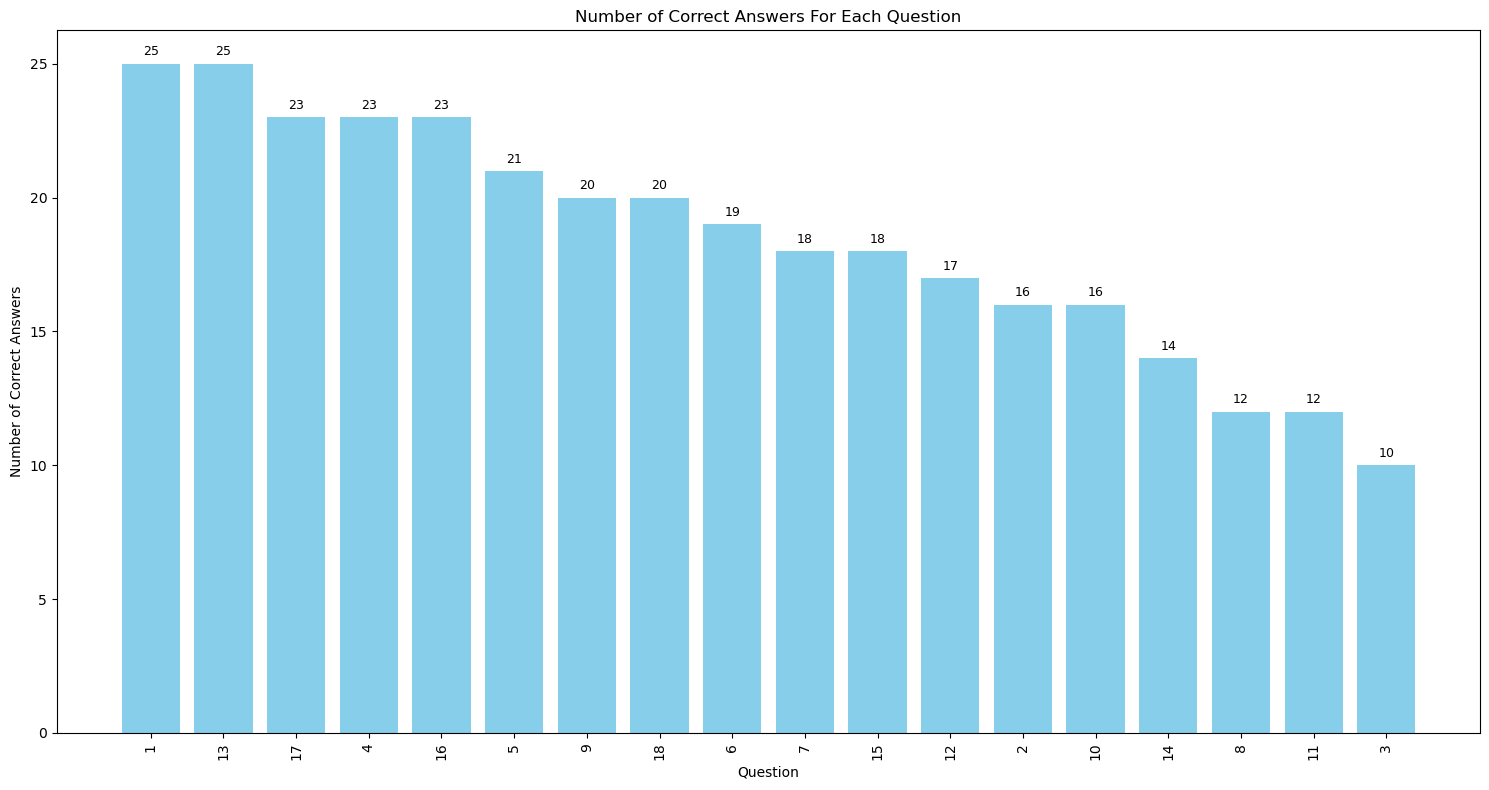

In [71]:
question_answers = merged_df.groupby('Question')['is_correct'].sum().reset_index()

question_answers = question_answers.sort_values(by='is_correct', ascending=False)

# Plotting
plt.figure(figsize=(15,8))
bars = plt.bar(range(len(question_answers)), question_answers['is_correct'], color='skyblue')

for idx, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom', fontsize=9)

plt.xticks(range(len(question_answers)), question_answers['Question'].values)

plt.ylabel('Number of Correct Answers')
plt.xlabel('Question')
plt.xticks(rotation=90)
plt.title('Number of Correct Answers For Each Question')
plt.tight_layout()
plt.show()

## Task 3a

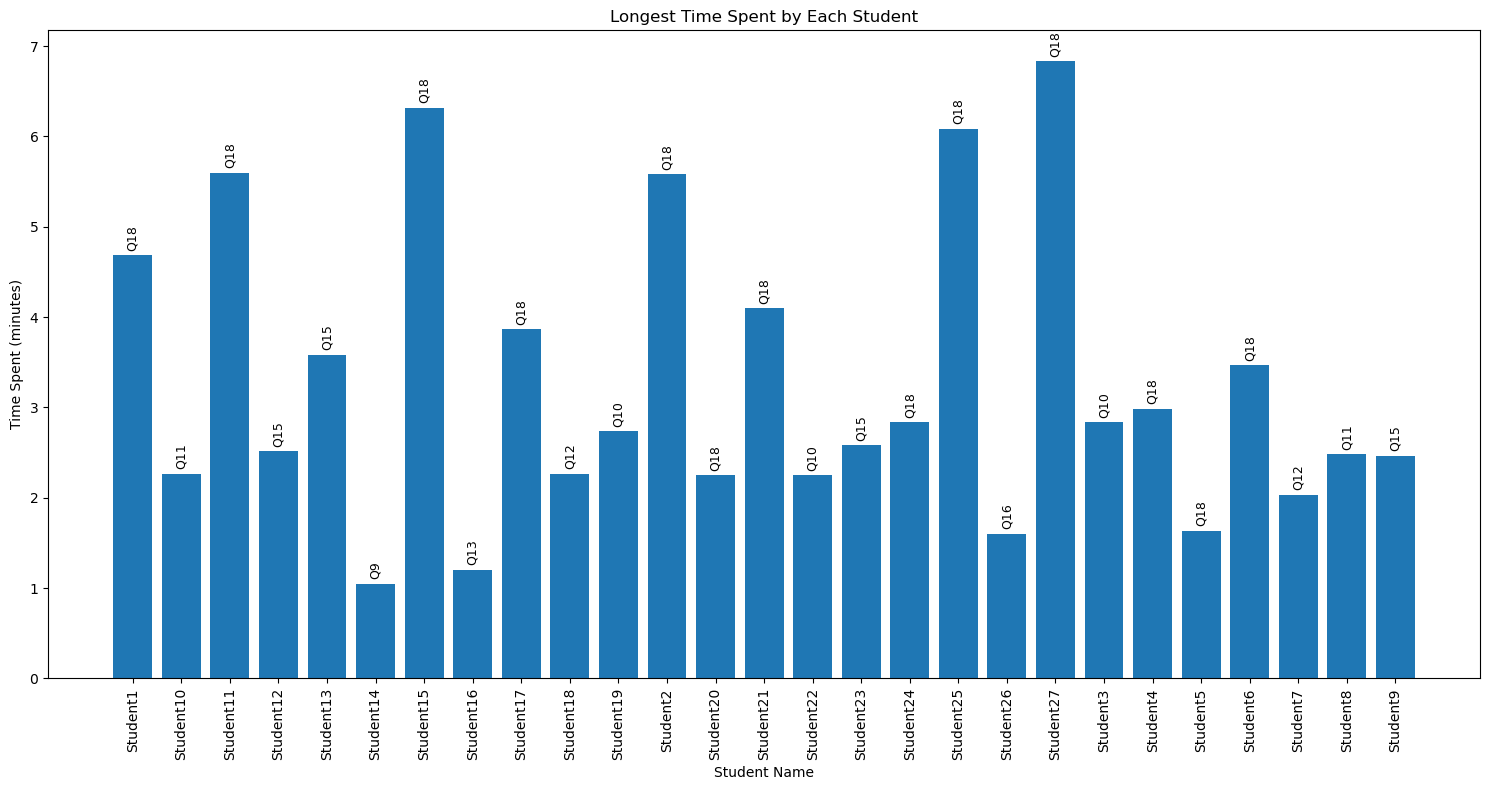

In [72]:
# Convert the time columns to datetime
merged_df['Time Launched'] = pd.to_datetime(merged_df['Time Launched'])
merged_df['Submitted Date/Time'] = pd.to_datetime(merged_df['Submitted Date/Time'])

# Calculate the time difference between the time launched and the time submitted
merged_df['Time Spent'] = merged_df['Submitted Date/Time'] - merged_df['Time Launched']

idx = merged_df.groupby('User Name')['Time Spent'].idxmax()

longest_times = merged_df.loc[idx]

# Plotting
plt.figure(figsize=(15, 8))
bars = plt.bar(longest_times.set_index('User Name')['Time Spent'].index, longest_times.set_index('User Name')['Time Spent'].dt.total_seconds()/60)
plt.ylabel('Time Spent (minutes)')
plt.xlabel('Student Name')
plt.title('Longest Time Spent by Each Student')

# Annotate each bar with the corresponding question
for bar, question in zip(bars, longest_times['Question']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.05, f'Q{question}', ha='center', va='bottom', fontsize=9, rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Task 3b

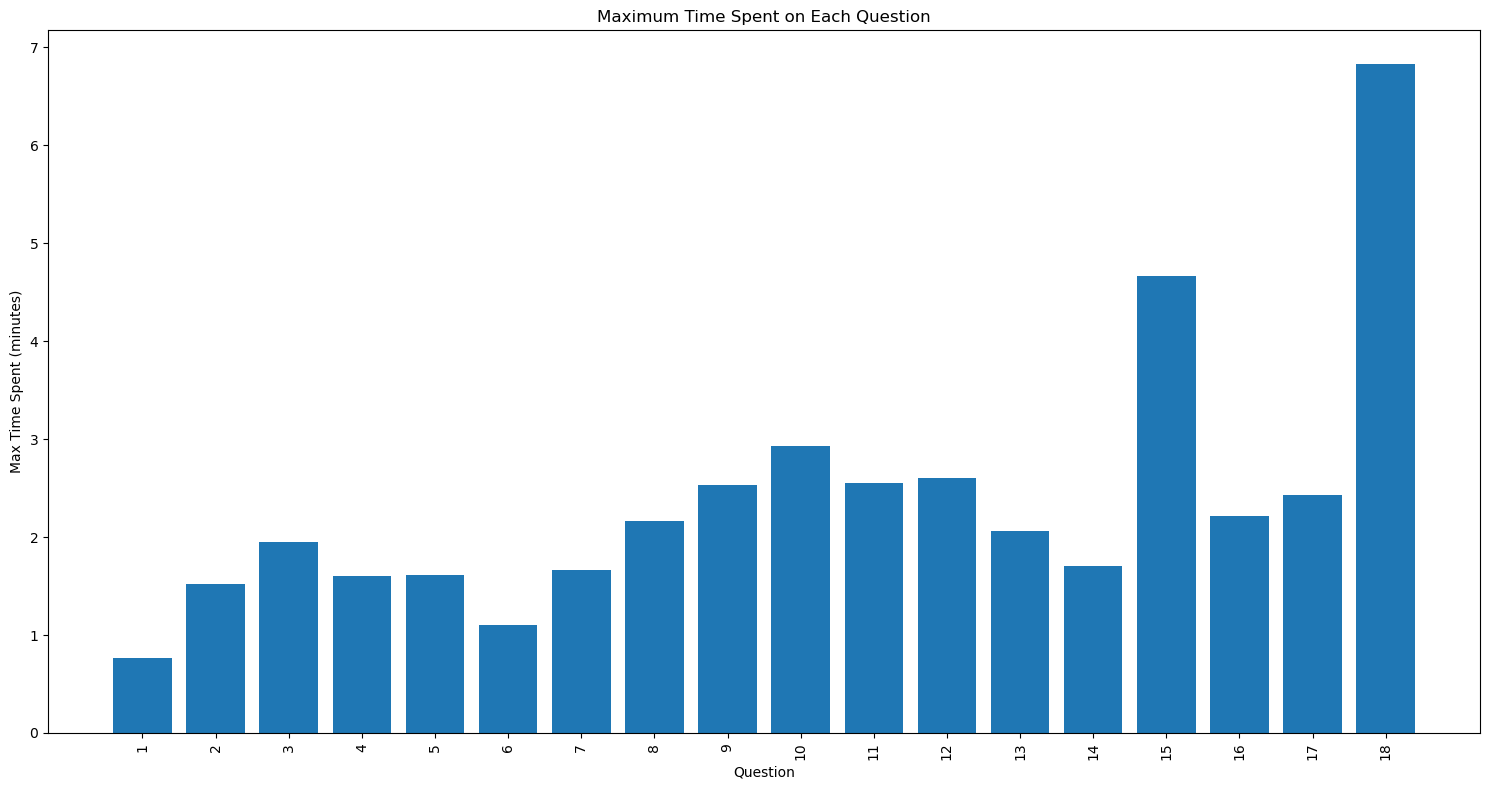

In [73]:
max_times_per_question = merged_df.groupby('Question')['Time Spent'].max()

sorted_max_times = max_times_per_question.sort_values(ascending=False)

def plot_max_avg_times(times, title, ylabel):
    plt.figure(figsize=(15, 8))
    plt.bar(times.index, times.dt.total_seconds()/60)
    plt.ylabel(ylabel)
    plt.xlabel('Question')
    plt.title(title)
    plt.xticks(ticks=times.index, labels=times.index, rotation=90)
    plt.tight_layout()
    plt.show()

plot_max_avg_times(sorted_max_times, 'Maximum Time Spent on Each Question', 'Max Time Spent (minutes)')

## Task 3c

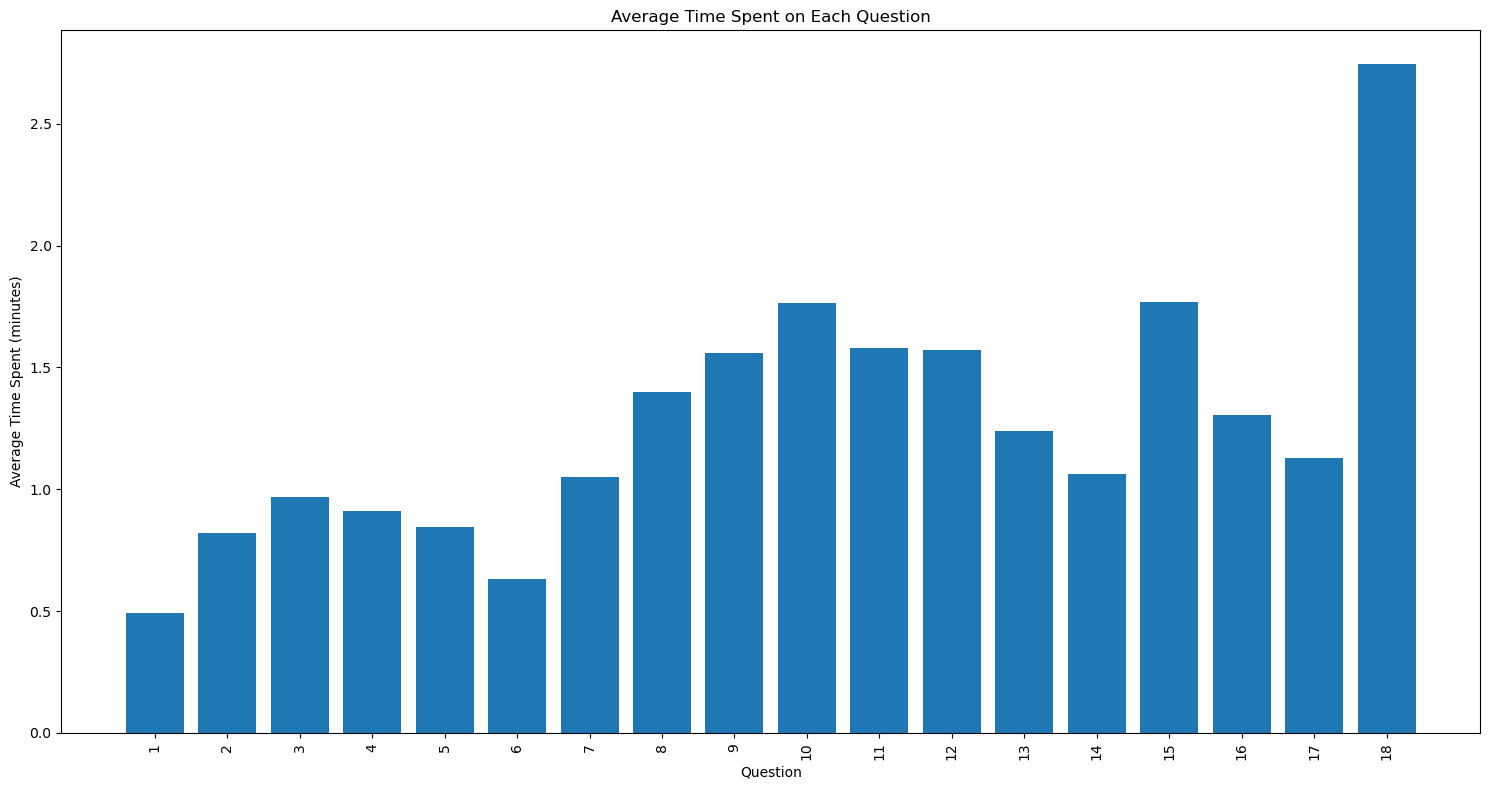

In [74]:
average_times = merged_df.groupby('Question')['Time Spent'].mean()
sorted_avg_times = average_times.sort_values(ascending=False)

plot_max_avg_times(sorted_avg_times, 'Average Time Spent on Each Question', 'Average Time Spent (minutes)')

## Task 4

The correlation between the number of correct answers and total time spent is: -0.54


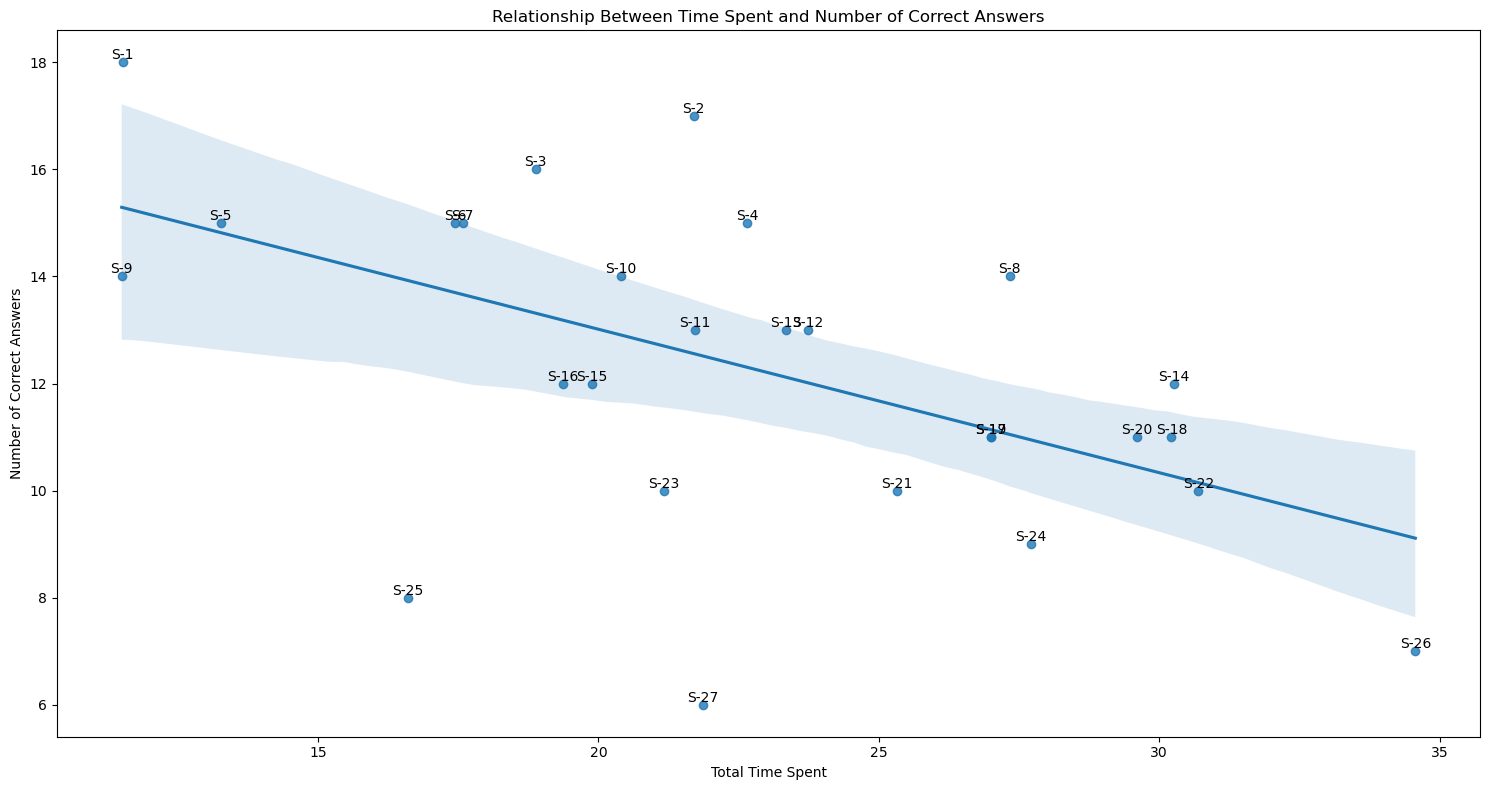

In [75]:
# Calculate the total time spent by each student
total_times = merged_df.groupby('User Name')['Time Spent'].sum()
total_times = total_times.sort_values(ascending=False)

total_times_df = total_times.reset_index()

merged_scores_times = pd.merge(student_scores, total_times_df, on='User Name')

merged_scores_times['Time Spent'] = merged_scores_times['Time Spent'].dt.total_seconds() / 60

correlation = merged_scores_times['is_correct'].corr(merged_scores_times['Time Spent'])

print(f"The correlation between the number of correct answers and total time spent is: {correlation:.2f}")

# Visualize the relationship between total time spent and number of correct answers using a scatter plot with a regression line
plt.figure(figsize=(15, 8))
sns.regplot(x='Time Spent', y='is_correct', data=merged_scores_times)

for i, row in merged_scores_times.iterrows():
    plt.text(row['Time Spent'], row['is_correct'], 'S-'+str(i+1), ha='center', va='bottom')

plt.ylabel('Number of Correct Answers')
plt.xlabel('Total Time Spent')
plt.title('Relationship Between Time Spent and Number of Correct Answers')
plt.tight_layout()
plt.show()

## Task 5

In [76]:
# Find all pairs of students who gave the same wrong answers for at least two questions.

# Get all the wrong answers
wrong_answers = merged_df[merged_df['is_correct'] == False]

# Get all the wrong answers for each student
wrong_answers_per_student = wrong_answers.groupby('User Name')['Question'].apply(list).reset_index()

# Get all the pairs of students who gave the same wrong answers for at least two questions
pairs = set()
for i, row in wrong_answers_per_student.iterrows():
    for j in range(i+1, len(wrong_answers_per_student)):
        row2 = wrong_answers_per_student.iloc[j]
        if len(set(row['Question']).intersection(row2['Question'])) >= 2:
            pairs.add(tuple(sorted([row['User Name'], row2['User Name']]))) # sorting to ensure (A, B) and (B, A) are treated the same

print(f"The pairs of students who gave the same wrong answers for at least two questions are: {len(pairs)}")

The pairs of students who gave the same wrong answers for at least two questions are: 209


## Task 6

The correlation between the number of correct answers and total time spent for the students with the shortest times is: -0.54


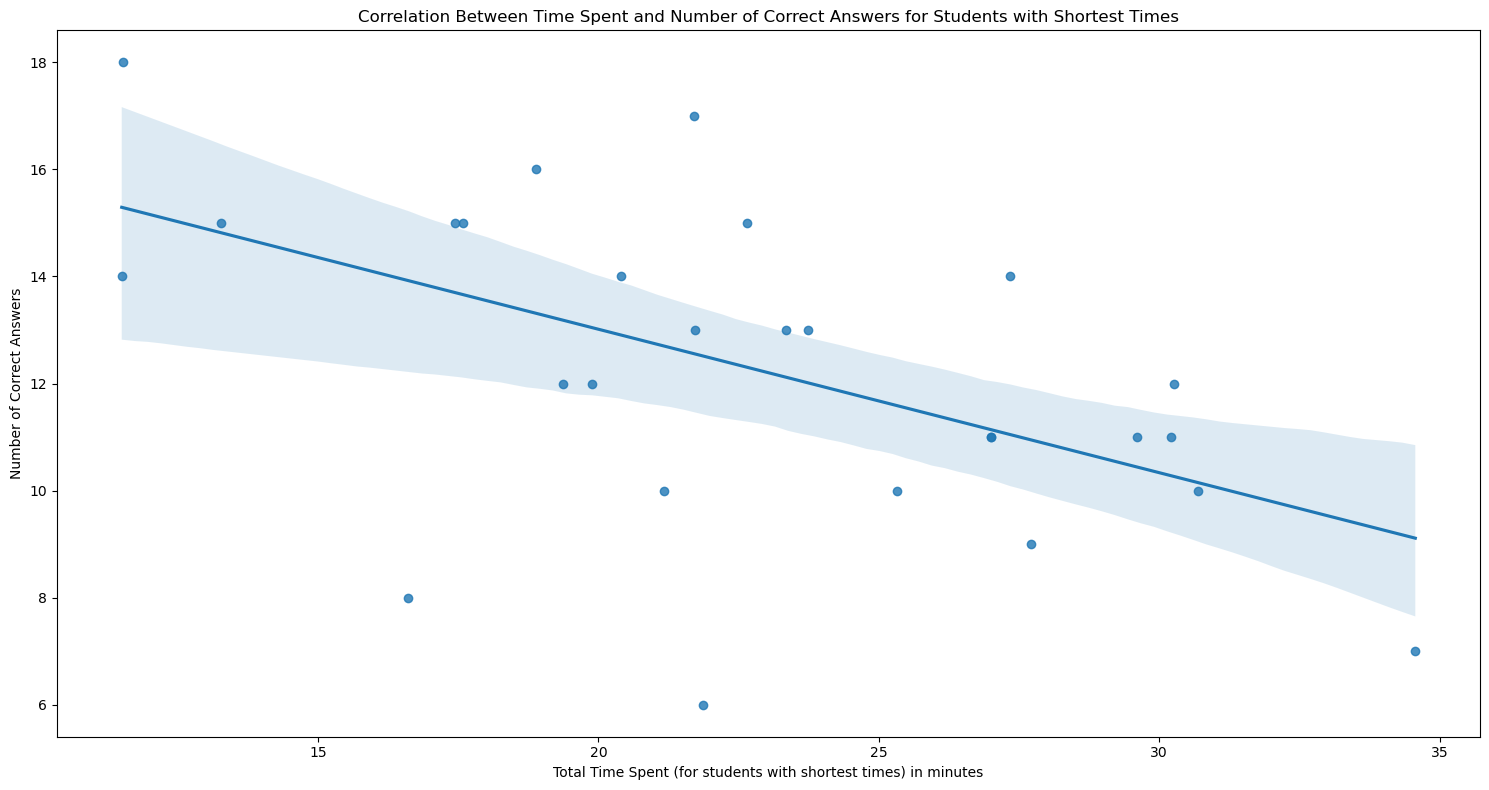

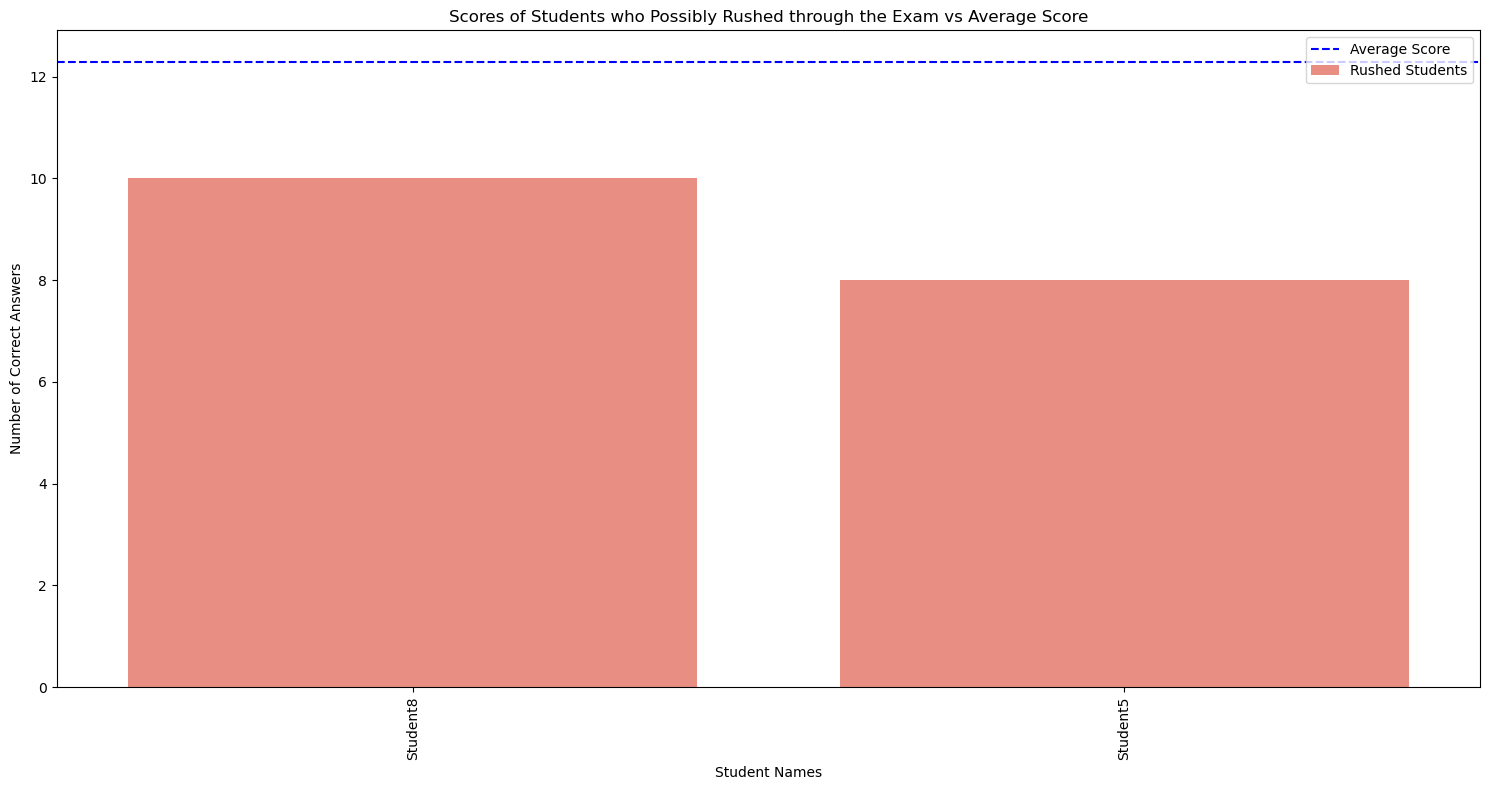

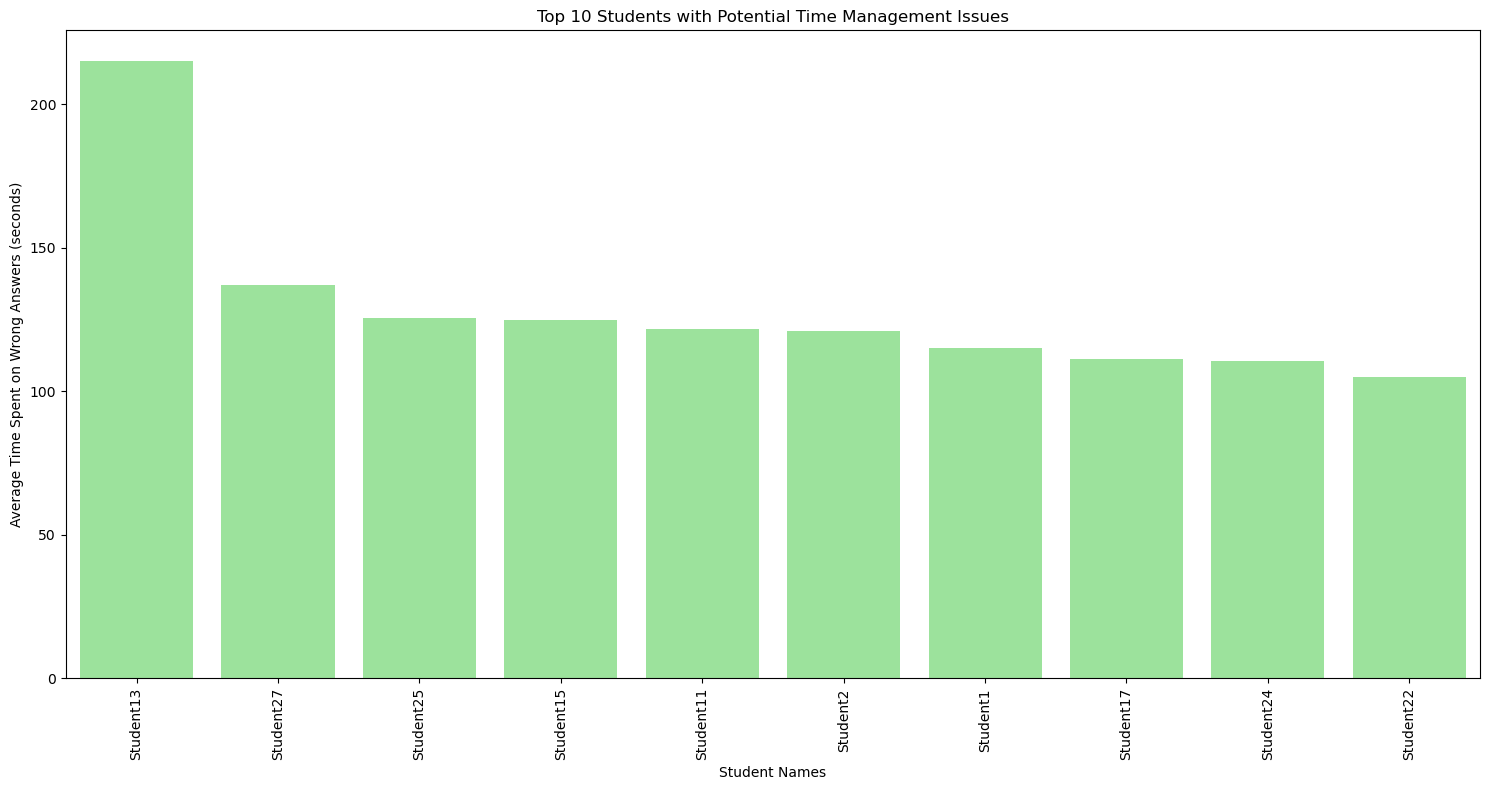

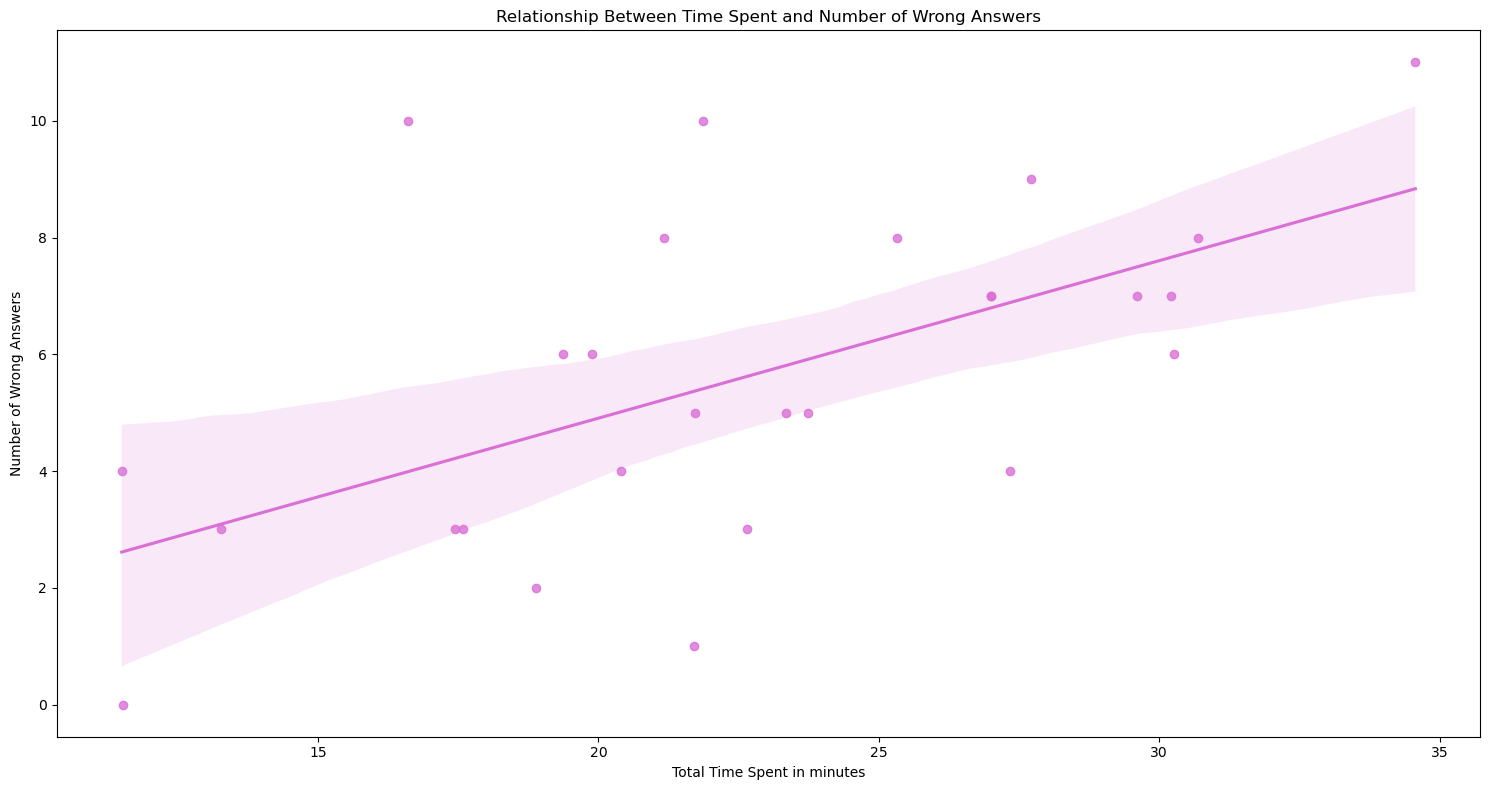

In [77]:
merged_df['Time Spent'] = (merged_df['Submitted Date/Time'] - merged_df['Time Launched']).dt.total_seconds()

# Students with the shortest time correlated to their scores
total_times = total_times.sort_values(ascending=True)
shortest_times_scores = pd.merge(total_times, student_scores, on='User Name')
shortest_times_scores['Time Spent'] = shortest_times_scores['Time Spent'].dt.total_seconds() / 60
correlation_shortest_time = shortest_times_scores['is_correct'].corr(shortest_times_scores['Time Spent'])

print(f"The correlation between the number of correct answers and total time spent for the students with the shortest times is: {correlation_shortest_time:.2f}")

# Visualize this relationship
plt.figure(figsize=(15, 8))
sns.regplot(x='Time Spent', y='is_correct', data=shortest_times_scores)
plt.ylabel('Number of Correct Answers')
plt.xlabel('Total Time Spent (for students with shortest times) in minutes')
plt.title('Correlation Between Time Spent and Number of Correct Answers for Students with Shortest Times')
plt.tight_layout()
plt.show()

# Determine the students who were rushing through the exam
merged_scores_times['Time Spent'] = merged_scores_times['Time Spent'] / 60
rushed_students = merged_scores_times[
    (merged_scores_times['Time Spent'] < merged_scores_times['Time Spent'].quantile(0.50)) &
    (merged_scores_times['is_correct'] < merged_scores_times['is_correct'].quantile(0.50))
    ]

# Visualization for students who possibly rushed through the exam
plt.figure(figsize=(15, 8))
sns.barplot(x=rushed_students['User Name'], y=rushed_students['is_correct'], color='salmon', label='Rushed Students')
plt.axhline(y=merged_scores_times['is_correct'].mean(), color='blue', linestyle='--', label='Average Score')
plt.ylabel('Number of Correct Answers')
plt.xlabel('Student Names')
plt.title('Scores of Students who Possibly Rushed through the Exam vs Average Score')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Time management issues
wrong_answers['Time Spent'] = wrong_answers['Time Spent'].dt.total_seconds()
long_time_wrong_answers = wrong_answers.groupby('User Name')['Time Spent'].mean().sort_values(ascending=False)
top_students_long_time_wrong = long_time_wrong_answers.head(10)

# Visualization for time management issues
plt.figure(figsize=(15, 8))
sns.barplot(x=top_students_long_time_wrong.index, y=top_students_long_time_wrong.values, color='lightgreen')
plt.ylabel('Average Time Spent on Wrong Answers (seconds)')
plt.xlabel('Student Names')
plt.title('Top 10 Students with Potential Time Management Issues')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Correlation with wrong answers
merged_df['is_wrong'] = ~merged_df['is_correct']
student_wrong_scores = merged_df.groupby('User Name')['is_wrong'].sum().reset_index()
merged_wrong_times = pd.merge(student_wrong_scores, total_times_df, on='User Name')
merged_wrong_times['Time Spent'] = merged_wrong_times['Time Spent'].dt.total_seconds() / 60
correlation_wrong_time = merged_wrong_times['is_wrong'].corr(merged_wrong_times['Time Spent'])

# Visualization for correlation with wrong answers
plt.figure(figsize=(15, 8))
sns.regplot(x='Time Spent', y='is_wrong', data=merged_wrong_times, color='orchid')
plt.ylabel('Number of Wrong Answers')
plt.xlabel('Total Time Spent in minutes')
plt.title('Relationship Between Time Spent and Number of Wrong Answers')
plt.tight_layout()
plt.show()